In [1]:
import os

os.chdir("../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import tqdm.auto as tqdm
import matplotlib.pyplot as plt

from modular_splicing.base_perturbations.swing_by_distance import (
    plot_swings_by_distance_to_features,
)
from modular_splicing.base_perturbations.stability_by_swing import (
    stability_by_swing_thresholds_all,
)
from modular_splicing.base_perturbations.perturbations import (
    probabilities_by_changed_sequence,
)

from modular_splicing.data_for_experiments.standardized_sample import (
    standardized_sample,
)
from modular_splicing.utils.run_batched import run_batched

from modular_splicing.models_for_testing.list import FM, AM, spliceai_400

In [4]:
cl = 400

In [5]:
mod = {
    "spliceai-400": spliceai_400[0].model,
    "fm": FM.non_binarized_model(1).model,
    "am": AM.non_binarized_model(1).model,
}

In [6]:
mcl = 500
limit = 10_000

In [7]:
xs_all, ys_all = standardized_sample("dataset_test_0.h5", amount=limit, cl=cl)
mask = ys_all.any(-1)
xs, ys = xs_all[mask], ys_all[mask]

In [8]:
yps = run_batched(
    lambda x: mod["spliceai-400"](x).softmax(-1)[:, :, 1:], xs_all, 100, pbar=tqdm.tqdm
)

In [9]:
thresholds_yps = [
    np.quantile(yps[:, :, c - 1], 1 - (ys_all == c).mean()) for c in (1, 2)
]

In [10]:
elements = [
    (
        x[idx - mcl // 2 : idx + cl + mcl // 2 + 1],
        x[idx : idx + cl + 1],
        x[:idx],
        x[idx + cl + 1 :],
        y[idx],
    )
    for x, y in zip(xs, ys)
    for idx in np.where(y)[0]
    if idx - mcl // 2 >= 0 and idx + cl + mcl // 2 + 1 < x.shape[0]
]

elements = elements[:limit]

In [11]:
wiggle = 0.1
thresholds_swing = np.arange(0, 0.06, 0.01)

In [12]:
quants, stables = stability_by_swing_thresholds_all(
    mod["spliceai-400"],
    [(x, y) for _, x, _, _, y in elements],
    thresholds_yps=thresholds_yps,
    thresholds_swing=thresholds_swing,
    wiggle=wiggle,
)

In [13]:
def get_perturbation_swing_results(m, *, include_context, limit=None):
    swings = []
    xfulls = []
    for i, (xfull, x, xl, xr, y) in tqdm.tqdm(list(enumerate(elements[:limit]))):
        kwargs = {} if not include_context else dict(context=dict(left=xl, right=xr))
        orig, modified = probabilities_by_changed_sequence(
            m, x, y, change_window=1, pbar=lambda x: x, **kwargs, bs=32
        )
        swings.append(np.abs(modified - orig).max(-1))
        xfulls.append(xfull)
        if i % 100 == 0:
            probabilities_by_changed_sequence.shelf.shelf.sync()
    return dict(swings=np.array(swings), xfulls=np.array(xfulls))

In [14]:
def get_all_perturbation_swing_results(limit):
    return dict(
        spliceai=get_perturbation_swing_results(
            mod["spliceai-400"], include_context=False, limit=limit
        ),
        FM=get_perturbation_swing_results(mod["fm"], include_context=True, limit=limit),
        AM=get_perturbation_swing_results(mod["am"], include_context=True, limit=limit),
    )

In [15]:
fm_less_sparse = FM.non_binarized_model(1, 0.178e-2 / 0.75 ** 3).model

In [16]:
results = get_all_perturbation_swing_results(5000)

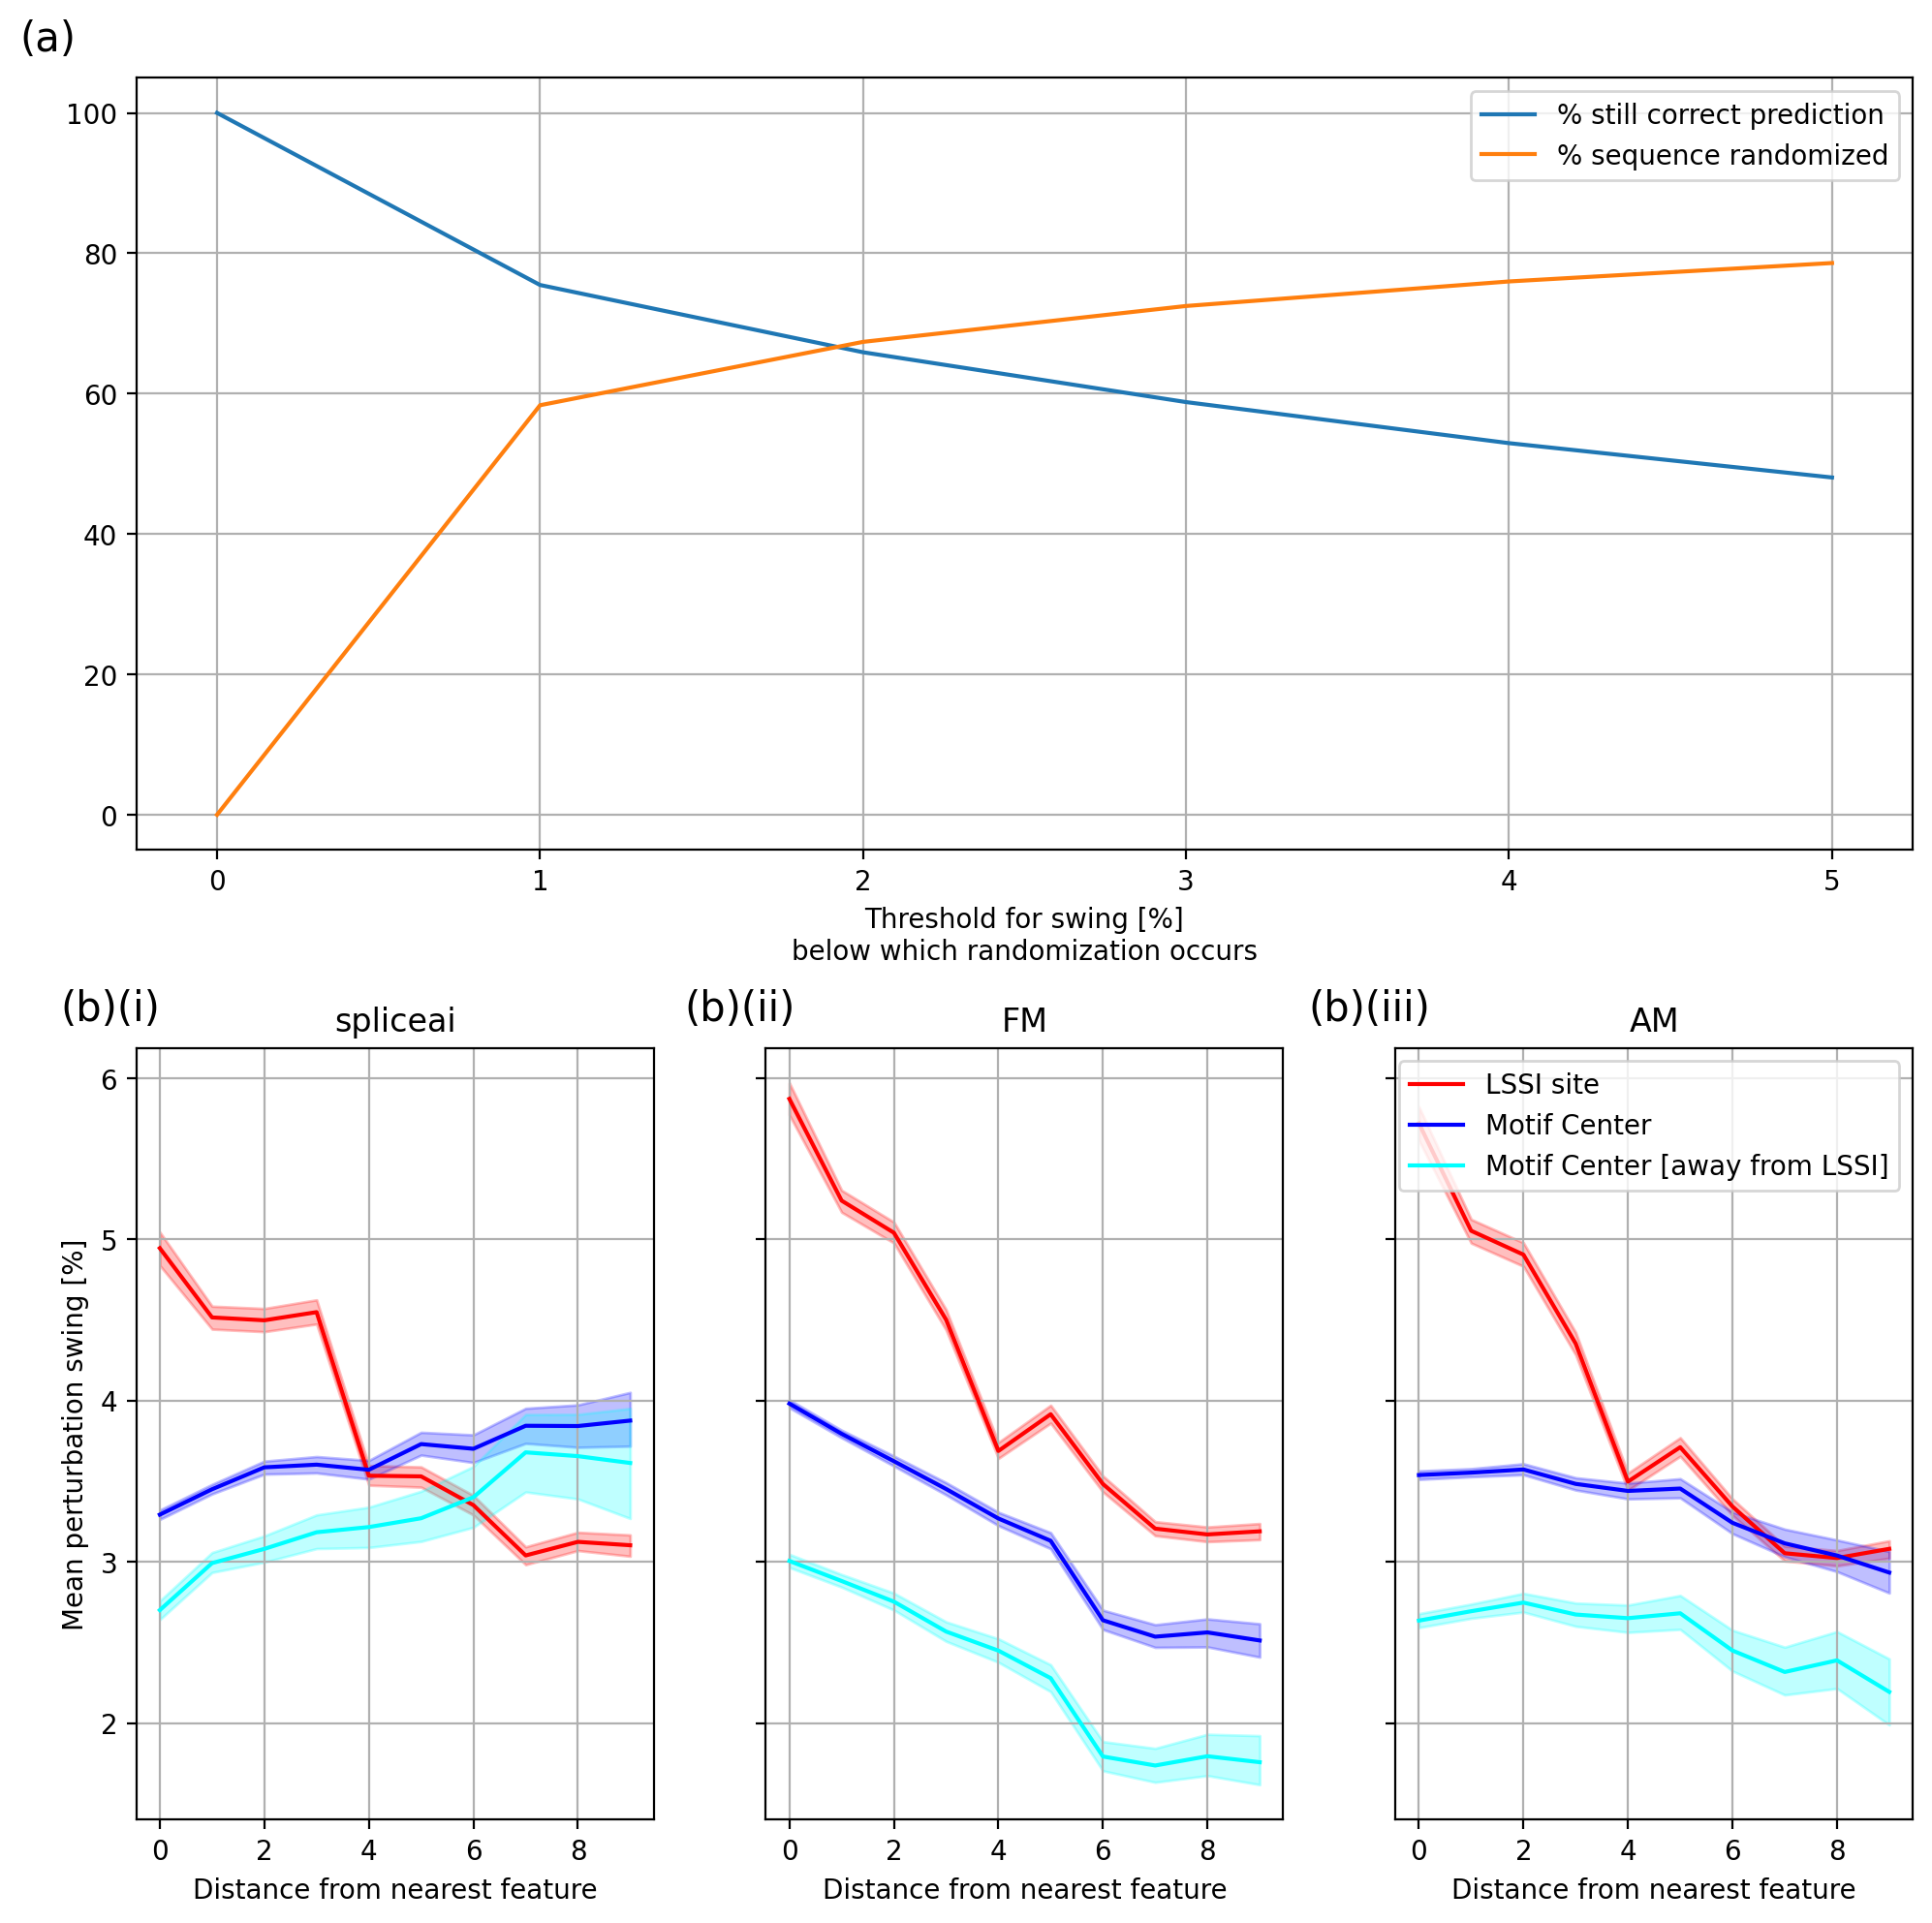

In [18]:
dist_divide = 1
max_value = 10

fig, axs = plt.subplots(2, 3, dpi=200, figsize=(10, 10), tight_layout=True, sharey=True)
# axs = [None, *axs[1]]

top = plt.subplot2grid((2, 3), (0, 0), colspan=3)
bot = axs[1]

top.plot(
    100 * thresholds_swing, 100 * stables.mean(0), label="% still correct prediction"
)
top.plot(100 * thresholds_swing, 100 * quants.mean(0), label="% sequence randomized")
top.set_xlabel("Threshold for swing [%]\nbelow which randomization occurs")
top.legend()
top.grid()

top.text(
    -0.05,
    1.05,
    "(a)",
    horizontalalignment="center",
    verticalalignment="center",
    transform=top.transAxes,
    fontsize=15,
)

for i, k, ax in zip(range(1, len(results) + 1), results, bot):
    plot_swings_by_distance_to_features(
        fm_less_sparse,
        **results[k],
        mcl=mcl,
        model_cl=cl,
        ax=ax,
        dist_divide=dist_divide,
        max_value=max_value,
    )
    ax.set_title(k)
    ax.text(
        -0.05,
        1.05,
        "(b)" + "(" + "i" * i + ")",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=15,
    )


bot[0].set_ylabel("Mean perturbation swing [%]")
bot[2].legend()

plt.show()